# Speed it up!

In [13]:
# !conda install dask
# !pip install numba
# !pip install memory_profiler
# !pip install matplotlib
# !pip install joblib

In [2]:
import math
import random
import numpy as np
import numba  # for next week...
import dask.array as da
from joblib import Parallel, delayed
from matplotlib import pyplot as plt

## First simple test: sum of numbers

Before we look at some more realistic and complex examples, let's start with something really simple. We just want to count all numbers from 0 to N.
And since we want to see what works best (here: = fastest!), we will measure the computation time using `time` or `timeit`.

### Pure Python Code

In [18]:
%%time
total = 0
for i in range(int(1e8)):
    total += i

CPU times: total: 4.36 s
Wall time: 8.32 s


In [8]:
# other example: best of 1,000,000 random numbers
%%time
best_of_a_million = []
for i in range(100):
    best = 0
    for k in range(1000000):
        number = random.random()
        if number > best:  # update
            best = number
    best_of_a_million.append(best)

CPU times: total: 8.2 s
Wall time: 11.3 s


### Best quess option: Numpy
Whenever we do something numerical in Python and we are concerned about run times, `Numpy` is usually a no-brainer for a first option to check. Compared to "pure" Python code numpy is much more efficient for handling numerical data, so in many cases it will be able to compute things much faster. Here as well:

In [16]:
%%time
result = np.arange(1e8).sum()  # carefull 10**8 won't work here!

CPU times: total: 156 ms
Wall time: 251 ms


In [17]:
result, total

(4999999950000000.0, 4999999950000000)

In [11]:
# other example: best of 1,000,000 random numbers
%%time
best_of_a_million = []
for i in range(100):
    best = np.max(np.random.random(1000000))
    best_of_a_million.append(best)

CPU times: total: 469 ms
Wall time: 689 ms


### Why is pure Python sooooo slow?
Numpy here is many times faster than pure Python code. Why is that?
We can distinguish two main reasons:

#### 1. Interpreted vs compiled code
It is actually examples like this that brings people to speak of Python as a *slow* programming language. 
And, in the present case, the main reason lies deep inside Python. Python code runs via an interpreter unlike in languages that run *compiled* code such as C, C++, Java, Rust, ...

Apparently, code examples as the one we just tested it converted into machine code by the interpreter in a way that is very far from optimal.

But what about Numpy, that's Python code as well, right?  
Yes and no. While Numpy is of course a Python library, some of it's core pieces were written in other, compiled languages such that the main performance bottleneck make better use of our hardware. For us this is great because we can simply call those functions from our Python code without having to worry about the many complications on the *lower-level* (=closer to machine code).

#### 2. Missing parallelization
Another issue is, that code which is executed in a Python interpreter cannot use our full hardware capacities. Due to the *Global Interpreter Lock (GIL)* such a programm can only run onw *thread* at a time. This has two disadvantages. First, this also means that no more than one CPU core is used at a time (although our machine might have 4, 8, 12, 16, or more cores). And second, *threads* might simply be waiting for something external to happen such as receiving information from a server or website request, so that our program is essentially computing nothing during this time.


#### 3. Dynamic Typing
Python is known for being *dynamically typed* which means that we do not have to specify the data type of our variables. They can be an integer first and later be something else, a list, a dictionary, a float ... whatever we like.
On the level of machine code, however, such a thing is not possible. Machine code is usually created for specific data types, for instance a 32-bit integer. As a consequence, the machine code that our Python interpreter produces is probably not well optimized for the data type that we finally use in our program. In addition, our program internally has to check the data type many times during execution. So, dynamic typing is clearly a larger factor for slowing down our Python programs.



--> Check this by running the pure Python code again and watching your CPU usage (e.g., in the task manager)!

## Check your CPU usage...
It is easiest to inspect you current CPU usage via the *task manager* (Windows) or *activity monitor* (MacOS).

If we want to divide our computations into several processes (or *workers*, *jobs*) than we first need to know how many cores we have in our machine. 

In [21]:
# option 1
import os
os.cpu_count()

16

In [19]:
# option 2
import joblib
joblib.cpu_count()

16

In [20]:
# option 3
import psutil

N_physical_cores = psutil.cpu_count(logical=False)
N_logical_cores = psutil.cpu_count(logical=True)
print(f"The number of physical/logical cores is {N_physical_cores}/{N_logical_cores}")

The number of physical/logical cores is 12/16


### Run multiple processes in parallel
While a single Python interpreter can only run one process, there are several tools and libraries that allow us to start multiple processes in Python. One of them is **joblib**.

In [10]:
%%time
results = [math.factorial(x) for x in range(10000)]

CPU times: total: 1.69 s
Wall time: 13.1 s


In [17]:
%%time
results = Parallel(n_jobs=2)(delayed(math.factorial)(x) for x in range(10000))

CPU times: total: 62.5 ms
Wall time: 6.62 s


In [18]:
%%time
results = Parallel(n_jobs=-1)(delayed(math.factorial)(x) for x in range(10000))

CPU times: total: 594 ms
Wall time: 2.57 s


### Parallelization - possible or not?
At first, it sounds really nice: Simply divide the work into *n* equal pieces and have *n* cores doing one piece at a time. So, our program will run *n* time faster!

Unfortunately, it is nearly never that simple.

First, we also have to see that it will cost computation time (=work) to split the computation steps and to later combine the result we get from the different processes.

And second, not every task can easily be divided into smaller pieces.
We had the example of cooking a pea soup. You can maybe speed up the cutting of vegetables step. But the peas need to cook 60 mintues and it makes no sense to divide this step over several workers/cooks.

Processes that conceptionally are trivial to run in parallel are called *embarassingly parallel*.

In [3]:
from joblib import Parallel, delayed

# Function to sum a range of numbers
def sum_range(start, end):
    total = 0
    for i in range(start, end):
        total += i
    return total

In [1]:
def total_sum_parallel(total_range, num_cores = 4):
    """Simple function to divide the counting over num_cores."""

    # Calculate the size of each split
    split_size = total_range // num_cores

    # Create the sub-ranges
    ranges = [(i, min(i + split_size, total_range)) for i in range(0, total_range, split_size)]

    # Parallel computation
    results = Parallel(n_jobs=num_cores)(delayed(sum_range)(start, end) for start, end in ranges)

    return sum(results)

In [11]:
%%time
total_sum_parallel(10**9, num_cores=16)

CPU times: total: 46.9 ms
Wall time: 15.4 s


499999999500000000

In [14]:
%%time
result = np.arange(1e9).sum()  # start with 1e7

CPU times: total: 2.14 s
Wall time: 4.63 s


## Dask
Dask is probably the most powerful Python library for parallel computations.
What makes `Dask` particularly nice is that it provides data types that resemble `numpy` datatypes (such as arrays) or `pandas` datatypes (Dataframes). This makes dask code look very familiar.

See also [Dask website](https://www.dask.org/).

In [12]:
%%time
work = da.arange(1e9).sum()
result = work.compute()

CPU times: total: 10.7 s
Wall time: 2.31 s


In [15]:
result

4.999999995e+17

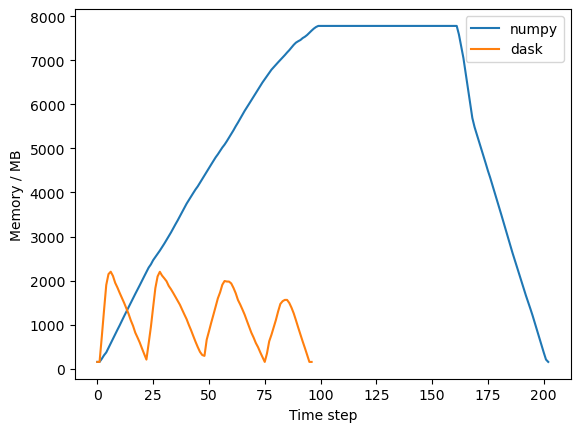

In [15]:
import numpy as np
import dask.array as da
from memory_profiler import memory_usage
import matplotlib.pyplot as plt

def sum_with_numpy():
    # Serial implementation
    np.arange(1e9).sum()

def sum_with_dask():
    # Parallel implementation
    work = da.arange(1e9).sum()
    work.compute()

memory_numpy = memory_usage(sum_with_numpy, interval=0.01)
memory_dask = memory_usage(sum_with_dask, interval=0.01)

# Plot results
plt.plot(memory_numpy, label='numpy')
plt.plot(memory_dask, label='dask')
plt.xlabel('Time step')
plt.ylabel('Memory / MB')
plt.legend()
plt.show()

## What does numpy need all this memory for? (and why does dask need less?)

--> "Chunking"

## Let's compare runs for different numbers of workers/jobs:

In [22]:
x = []
for n in range(1, 9):
    time_taken = %timeit -r 1 -o da.arange(1e8).sum().compute(num_workers=n)
    x.append(time_taken.average)

226 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
170 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
140 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
158 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
155 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
147 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
122 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
122 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)


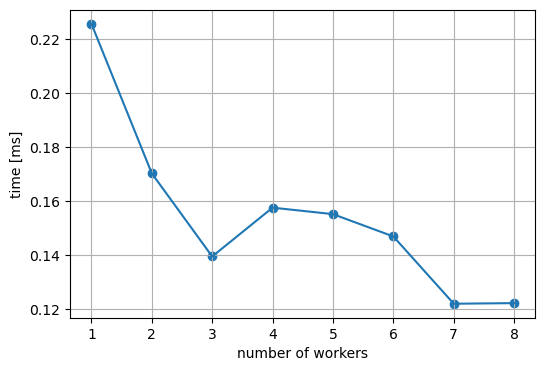

In [23]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.scatter(np.arange(1, 9), x)
ax.plot(np.arange(1, 9), x)
plt.xlabel("number of workers")
plt.ylabel("time [ms]")
plt.grid(True)